In [340]:
%matplotlib inline

from datetime import datetime
from datetime import timedelta

import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

le = preprocessing.LabelEncoder()

def convert_to_seconds_since_midnight(t):
    return (t.hour * 3600) + (t.minute * 60) + t.second + (t.microsecond / 1000000.0)

def add_features(df, le):
    df["start_time"] = df.apply(lambda x: convert_to_seconds_since_midnight(x["start_datetime"]), axis=1)
    df["end_time"] = df.apply(lambda x: convert_to_seconds_since_midnight(x["end_datetime"]), axis=1)
    df["start_day_of_week"] = df["start_datetime"].dt.dayofweek
    df["end_day_of_week"] = df["end_datetime"].dt.dayofweek
    df["duration"] = df["end_datetime"].astype(np.int64) - df["start_datetime"].astype(np.int64)
    
    for label in ["place", "type", "location", "activity"]:
        if label in df.columns:
            df["{label}_encoded".format(label=label)] = le.fit_transform(df[label])

    return df

def load_data(filename, le, user=None):
    data = pd.read_table(filename, header=0)
    data = data.rename(columns=lambda x: x.strip().lower().replace(" ", "_"))
    
    data["start_datetime"] = pd.to_datetime(data["start_time"], errors='coerce')
    data["end_datetime"] = pd.to_datetime(data["end_time"], errors='coerce')
    data["user"] = user
    
    bad_rows = data[data.start_datetime > data.end_datetime]
    if not bad_rows.empty:
        data.loc[bad_rows.index,['start_datetime','end_datetime']] = data.loc[bad_rows.index,['end_datetime','start_datetime']].values
    
    data = add_features(data, le)

    return data

sensors_training = pd.concat([load_data('UserA_Sensors_training.csv', le, 'A'), load_data('UserB_Sensors_training.csv', le, 'B')])
adls_training = pd.concat([load_data('UserA_ADLs_training.csv', le, 'A'), load_data('UserB_ADLs_training.csv', le, 'B')])

sensors_test = load_data('Classify.csv', le)
adls_test = load_data('ADLS_classifying.csv', le)

In [341]:
def convert_to_scikit_format(df):
    X = df
    for label in ["user", "location", "type", "place", "activity", "start_datetime", "end_datetime"]:
        if label in X.columns:
            X = X.drop(label, axis=1)
    y = df["user"]
    
    return X, y

sensor_X_train, sensor_y_train = convert_to_scikit_format(sensors_training)
sensor_X_test, _ = convert_to_scikit_format(sensors_test)

adls_X_train, adls_y_train = convert_to_scikit_format(adls_training)
adls_X_test, _ = convert_to_scikit_format(adls_test)


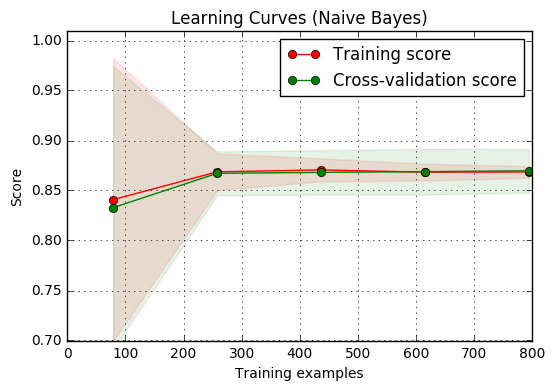

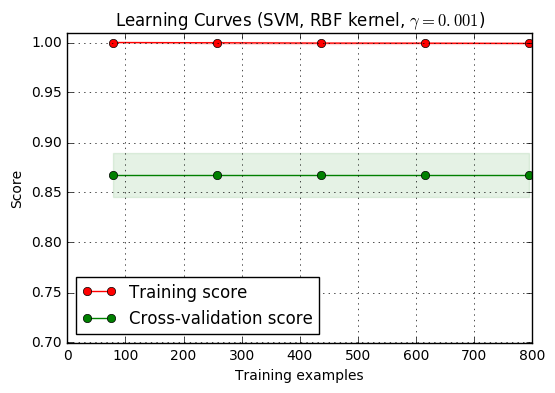

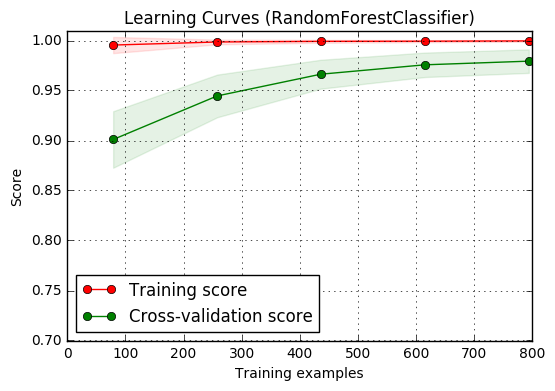

In [342]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

X, y = sensor_X_train, sensor_y_train

title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)

title = "Learning Curves (RandomForestClassifier)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = RandomForestClassifier()
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

In [343]:
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

sensor_classifier = RandomForestClassifier()
sensor_classifier.fit(sensor_X_train, sensor_y_train)

sensors_test['predicted_user'] = sensor_classifier.predict(sensor_X_test)
pd.options.display.max_rows = 400
sensors_test.drop(["start_time", "end_time", "user", "start_day_of_week", "end_day_of_week", "place_encoded", "duration", "type_encoded", "location_encoded"], axis=1)

,location,type,place,start_datetime,end_datetime,predicted_user
0,Seat,Pressure,Living,2011-12-02 01:19:09,2011-12-02 02:08:17,B
1,Basin,PIR,Bathroom,2011-12-02 02:09:33,2011-12-02 02:13:56,B
2,Bed,Pressure,Bedroom,2011-12-02 02:15:55,2011-12-02 12:15:19,A
3,Toilet,Flush,Bathroom,2011-12-02 12:20:40,2011-12-02 12:21:09,B
4,Basin,PIR,Bathroom,2011-12-02 12:20:41,2011-12-02 12:20:46,A
5,Cabinet,Magnetic,Bathroom,2011-12-02 12:21:02,2011-12-02 12:21:06,B
6,Shower,PIR,Bathroom,2011-12-02 12:21:19,2011-12-02 12:25:40,B
7,Cupboard,Magnetic,Kitchen,2011-12-02 12:27:47,2011-12-02 12:28:03,B
8,Fridge,Magnetic,Kitchen,2011-12-02 12:28:45,2011-12-02 12:29:02,B
9,Toaster,Electric,Kitchen,2011-12-02 12:29:08,2011-12-02 12:31:50,B


In [344]:
adls_classifier = RandomForestClassifier()
adls_classifier.fit(adls_X_train, adls_y_train)
adls_test['predicted_user'] = adls_classifier.predict(adls_X_test)
pd.options.display.max_rows = 400
adls_test.drop(["start_time", "end_time", "user", "start_day_of_week", "end_day_of_week", "activity_encoded", "duration"], axis=1)

,activity,start_datetime,end_datetime,predicted_user
0,Grooming,2011-12-01 10:20:59,2011-12-02 12:20:41,A
1,Showering,2011-12-02 12:21:19,2011-12-02 12:25:40,A
2,Breakfast,2011-12-01 11:35:49,2011-12-02 12:27:47,A
3,Spare_Time/TV,2011-12-02 12:37:47,2011-12-02 14:46:29,A
4,Lunch,2011-12-02 14:47:00,2011-12-02 15:20:00,A
5,Spare_Time/TV,2011-12-02 15:24:05,2011-12-02 15:55:12,A
6,Grooming,2011-12-02 15:56:02,2011-12-02 15:57:55,A
7,Spare_Time/TV,2011-12-02 15:58:00,2011-12-02 16:36:05,A
8,Toileting,2011-12-02 16:37:27,2011-12-02 16:47:27,A
9,Spare_Time/TV,2011-12-02 16:47:39,2011-12-02 19:39:08,A


In [321]:
sensor_X_train

,start_time,end_time,start_day_of_week,end_day_of_week,duration,place_encoded,type_encoded,location_encoded
0,8879.0,37091.0,0,0,28212000000000,1,4,1
1,37284.0,37291.0,0,0,7000000000,0,2,2
2,37304.0,37411.0,0,0,107000000000,0,3,0
3,37382.0,37416.0,0,0,34000000000,0,1,11
4,37544.0,37926.0,0,0,382000000000,0,3,9
5,38063.0,38081.0,0,0,18000000000,3,2,5
6,38084.0,38237.0,0,0,153000000000,3,2,4
7,38280.0,38561.0,0,0,281000000000,3,0,10
8,38313.0,38320.0,0,0,7000000000,3,2,5
9,38489.0,38496.0,0,0,7000000000,3,2,4
